## Simple demonstration of statistical arbitrage

In [1]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set()
%matplotlib inline

In [2]:
# read prices
Pe = pd.read_csv('data/JPM.csv')
Pb = pd.read_csv('data/XLF.csv')

In [3]:
# ensure the dates match up
matched_data = pd.merge(Pe, Pb, on = 'date')
matched_data = matched_data.sort_values(by=['date'], ascending = True).reset_index()

# use adjusted close prices for the study
price_e = matched_data['adjclose_x'].values
price_b = matched_data['adjclose_y'].values

In [4]:
# compute the (daily) return rate
Re = diff(price_e) / price_e[:-1]
Rb = diff(price_b) / price_b[:-1]

# time interval = daily (~252 trading days in a year)
dt = 1.0 / 252

#### price evolution equation 
$$ R_e(t) = \alpha \cdot dt + \beta \cdot R_b(t) + dX(t) $$

In [5]:
# use linear regression to find alpha and beta
beta, alphaXdt = polyfit(Rb, Re, 1)
alpha = alphaXdt / dt

# detrending to find dX
R_fit = polyval([beta, alphaXdt], Rb)
dX = R_fit - Re

# modeling X
X = cumsum(dX)

In [6]:
# ensure that X[-1] = 0
assert X[-1] <= 0.001 

### Modeled as Ornstein-Uhlenbeck process
$$ dX = \kappa*(m - X)*dt + \sigma*dW$$

in discrete form:
 $$ X[i+1] - X[i] = \kappa*(m - X[i])*dt + \sigma*sqrt(t)*dW $$
or
 $$ X[i+1] = X[i]*(1-\kappa*dt) + \kappa*m*dt + \sigma*sqrt(t)*dW $$

In [7]:
# solve for kappa and m
_1_kappaXdt, kappaXmXdt = polyfit(X[:-1], X[1:], 1)
kappa = (1 - _1_kappaXdt) / dt
m = kappaXmXdt / kappa / dt

# solve for sigma
X_fit = polyval([_1_kappaXdt, kappaXmXdt], X[:-1])
sigma = std(X_fit - X[1:])
sigma_t = sigma / sqrt(dt)

In [8]:
# compute for z-value
sigma_eq = sigma_t / sqrt(2*kappa)
z = (X - m) / sigma_eq

In [9]:
# = in practice, if we believe in the Ornstein-Uhlenbeck model,
# = X follows a Gaussian distribution, hence
m_prac        = mean(X)
sigma_eq_prac =  std(X)
z_prac = (X - m_prac) / sigma_eq_prac

In [10]:
print('difference between theoretical and observed:', abs(round(mean(abs(z - z_prac) / 0.5*(z + z_prac) * 100), 3)) , '%')

difference between theoretical and observed: 0.208 %


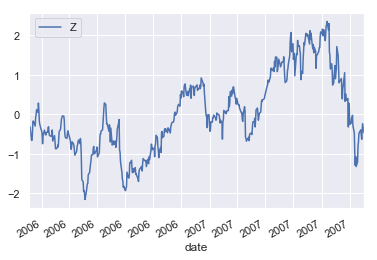

In [11]:
# plotting
z_series = pd.Series(z, index = matched_data['date'].index[-len(z):], name = 'Z', dtype=float64)
D = pd.DataFrame({'date': matched_data['date'][-len(z_series):], 'Z': z_series})
D['date'] = pd.to_datetime(D['date'])
D.plot(
    x='date', y='Z', 
    xticks = pd.date_range(D['date'].values[0], D['date'].values[-1], freq = '2M'),
    xlim = [matched_data['date'].values[-len(z_series)], matched_data['date'].values[-1]],
);